## Manhattan plot for trans-eQTLs

Initial look at the trans-eQTLs, and get some basic plots:
 - Manhattan plot
 - Q-Q plot
 
Define the input directories and variables here:

In [1]:
import numpy as np
import pygtrie
from statsmodels.stats import multitest
import collections
import os

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib
import sys
sys.path.append('../')
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 24, colors = 'banskt', dpi = 72)

In [2]:
def read_tejaas(filename):
    rsidlist = list()
    bplist   = list()
    pvallist = list()
    qlist    = list()
    maflist  = list()
    mulist   = list()
    siglist  = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            bppos = int(linesplit[2])
            pval = float(linesplit[7])
            qval = float(linesplit[4])
            mu   = float(linesplit[5])
            sig  = float(linesplit[6])
            maf  = float(linesplit[3])
            rsidlist.append(rsid)
            bplist.append(bppos)
            pvallist.append(pval)
            qlist.append(qval)
            maflist.append(maf)
            mulist.append(mu)
            siglist.append(sig)
    return rsidlist, pvallist, bplist, qlist, maflist, mulist, siglist

def read_tejaas_old(filename):
    rsidlist = list()
    bplist   = list()
    pvallist = list()
    qlist    = list()
    maflist  = list()
    mulist   = list()
    siglist  = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[0]
            bppos = int(linesplit[1])
            qval = float(linesplit[2])
            mu   = float(linesplit[3])
            sig  = float(linesplit[4])
            pval = float(linesplit[5])
            maf  = float(linesplit[7])
            rsidlist.append(rsid)
            bplist.append(bppos)
            pvallist.append(pval)
            qlist.append(qval)
            maflist.append(maf)
            mulist.append(mu)
            siglist.append(sig)
    return rsidlist, pvallist, bplist, qlist, maflist, mulist, siglist

def read_tejaas_all_chrom_old(filefmt, chrmlist):
    gwrsids = list()
    gwpvals = list()
    gwnsnps = dict()
    gwbppos = dict()
    gwqvals = list()
    gwmafs  = list()
    
    for chrm in chrmlist:
        filepath = filefmt.format(chrm)
        rsids, pvals, bplist, qlist, maflist, mulist, siglist = read_tejaas_old(filepath)
        gwrsids += rsids
        gwpvals += pvals
        gwqvals += qlist
        gwmafs  += maflist
        gwnsnps[chrm] = len(rsids)
        gwbppos[chrm] = np.array(bplist)
        
    gwpvals = np.array(gwpvals)
    pmax  = np.max(gwpvals[np.where(gwpvals > 0)])
    nonzero_pvals = gwpvals.copy()
    nonzero_pvals[np.where(gwpvals == 0)] = pmax
    
    return gwrsids, gwnsnps, gwbppos, nonzero_pvals

def read_tejaas_all_chrom(filefmt, chrmlist):
    gwrsids = list()
    gwpvals = list()
    gwnsnps = dict()
    gwbppos = dict()
    gwqvals = list()
    gwmafs  = list()
    
    for chrm in chrmlist:
        filepath = filefmt.format(chrm)
        rsids, pvals, bplist, qlist, maflist, mulist, siglist = read_tejaas(filepath)
        gwrsids += rsids
        gwpvals += pvals
        gwqvals += qlist
        gwmafs  += maflist
        gwnsnps[chrm] = len(rsids)
        gwbppos[chrm] = np.array(bplist)
        
    gwpvals = np.array(gwpvals)
    pmax  = np.max(gwpvals[np.where(gwpvals > 0)])
    nonzero_pvals = gwpvals.copy()
    nonzero_pvals[np.where(gwpvals == 0)] = pmax
    
    return gwrsids, gwnsnps, gwbppos, nonzero_pvals

def read_Q_tejaas_all_chrom(filefmt, chrmlist):
    gwrsids = list()
    gwpvals = list()
    gwnsnps = dict()
    gwbppos = dict()
    gwqvals = list()
    gwmafs  = list()
    
    for chrm in chrmlist:
        filepath = filefmt.format(chrm)
        rsids, pvals, bplist, qlist, maflist, mulist, siglist = read_tejaas(filepath)
        gwrsids += rsids
        gwpvals += pvals
        gwqvals += qlist
        gwmafs  += maflist
        gwnsnps[chrm] = len(rsids)
        gwbppos[chrm] = np.array(bplist)
        
    gwqvals = np.array(gwqvals)
    
    return gwrsids, gwnsnps, np.array(gwmafs), gwqvals

def read_Qstats_tejaas_all_chrom(filefmt, chrmlist):
    gwrsids = list()
    gwpvals = list()
    gwnsnps = dict()
    gwbppos = dict()
    gwqvals = list()
    gwmus   = list()
    gwsigs  = list()
    for chrm in chrmlist:
        filepath = filefmt.format(chrm)
        rsids, pvals, bplist, qlist, maflist, mulist, siglist = read_tejaas(filepath)
        gwrsids += rsids
        gwpvals += pvals
        gwqvals += qlist
        gwmus   += mulist
        gwsigs  += siglist
        gwnsnps[chrm] = len(rsids)
        gwbppos[chrm] = np.array(bplist)
        
    gwqvals = np.array(gwqvals)
    return gwrsids, gwnsnps, gwqvals, np.array(gwmus), np.array(gwsigs)

#### Load results for TEJAAS

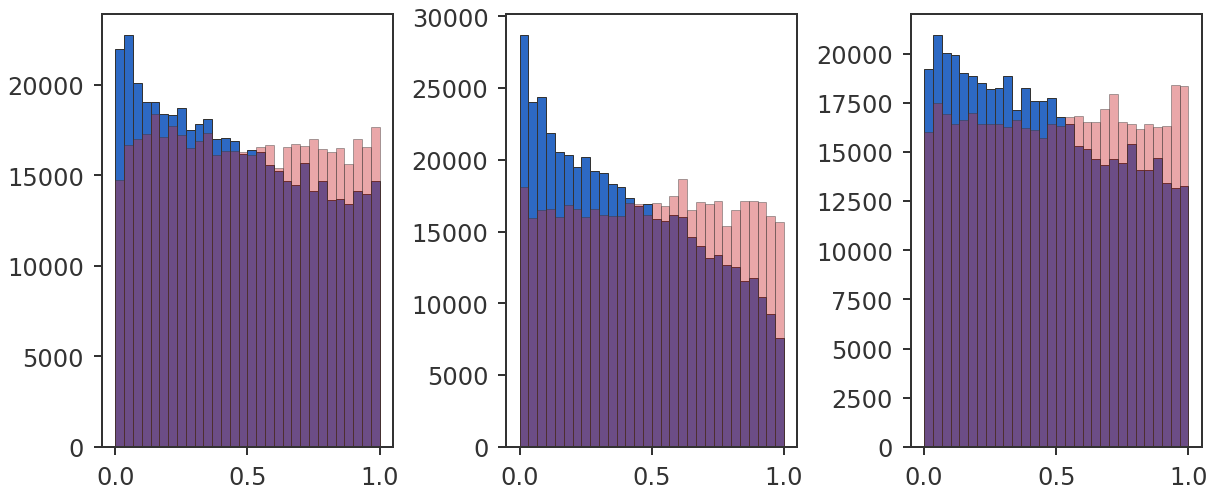

In [28]:
resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2_062020_EUR/"
tissuelist = ["gtex_v8-ms", "gtex_v8-as", "gtex_v8-sse"]
tejaas_preproc = ["raw"] # "raw_oneref"

tejaas_method_variant  = ["permnull_sb0.1_knn30"]

rrfile = "rr.txt"
chrmlist = [10,11]

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals = -np.log10(gwpvals)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[1]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids2, gwnsnps2, gwbppos2, gwpvals2 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals2 = -np.log10(gwpvals2)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[2]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids3, gwnsnps3, gwbppos3, gwpvals3 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals3 = -np.log10(gwpvals3)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas_rand/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwbppos, gwpvals_rand = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals_rand = -np.log10(gwpvals_rand)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[1]}/tejaas_rand/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids2, gwnsnps2, gwbppos2, gwpvals2_rand = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals2_rand = -np.log10(gwpvals2_rand)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[2]}/tejaas_rand/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids3, gwnsnps3, gwbppos3, gwpvals3_rand = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals3_rand = -np.log10(gwpvals3_rand)


fig = plt.figure(figsize = (17, 7))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

nplotsnp = min(500000, gwpvals.shape[0])
nchoose = np.sort(np.random.choice(gwpvals.shape[0], size = nplotsnp, replace = False))
ax1.hist(gwpvals[nchoose], bins=30)
# ax1.set_title(f"{tejaas_method_variant[0]}")
# ax1.set_ylim(0,13500)

nplotsnp = min(500000, gwpvals2.shape[0])
nchoose = np.sort(np.random.choice(gwpvals2.shape[0], size = nplotsnp, replace = False))
ax2.hist(gwpvals2[nchoose], bins=30)
# ax2.set_title(f"{tejaas_method_variant[0]}")
# ax2.set_ylim(0,13500)

nplotsnp = min(500000, gwpvals3.shape[0])
nchoose = np.sort(np.random.choice(gwpvals3.shape[0], size = nplotsnp, replace = False))
ax3.hist(gwpvals3[nchoose], bins=30)
# ax3.set_title(f"{tejaas_method_variant[0]}")
# ax3.set_ylim(0,13500)

nplotsnp = min(500000, gwpvals_rand.shape[0])
nchoose = np.sort(np.random.choice(gwpvals_rand.shape[0], size = nplotsnp, replace = False))
ax1.hist(gwpvals_rand[nchoose], bins=30, label="rand", alpha=0.4)
# ax1.set_title(f"{tejaas_method_variant[0]}")
# ax1.set_ylim(0,13500)

nplotsnp = min(500000, gwpvals2_rand.shape[0])
nchoose = np.sort(np.random.choice(gwpvals2_rand.shape[0], size = nplotsnp, replace = False))
ax2.hist(gwpvals2_rand[nchoose], bins=30, label="rand", alpha=0.4)
# ax2.set_title(f"{tejaas_method_variant[0]}")
# ax2.set_ylim(0,13500)

nplotsnp = min(500000, gwpvals3_rand.shape[0])
nchoose = np.sort(np.random.choice(gwpvals3_rand.shape[0], size = nplotsnp, replace = False))
ax3.hist(gwpvals3_rand[nchoose], bins=30, label="rand", alpha=0.4)
# ax3.set_title(f"{tejaas_method_variant[0]}")
# ax3.set_ylim(0,13500)

plt.tight_layout()
plt.show()

/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:101: RuntimeWarning: invalid value encountered in greater
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


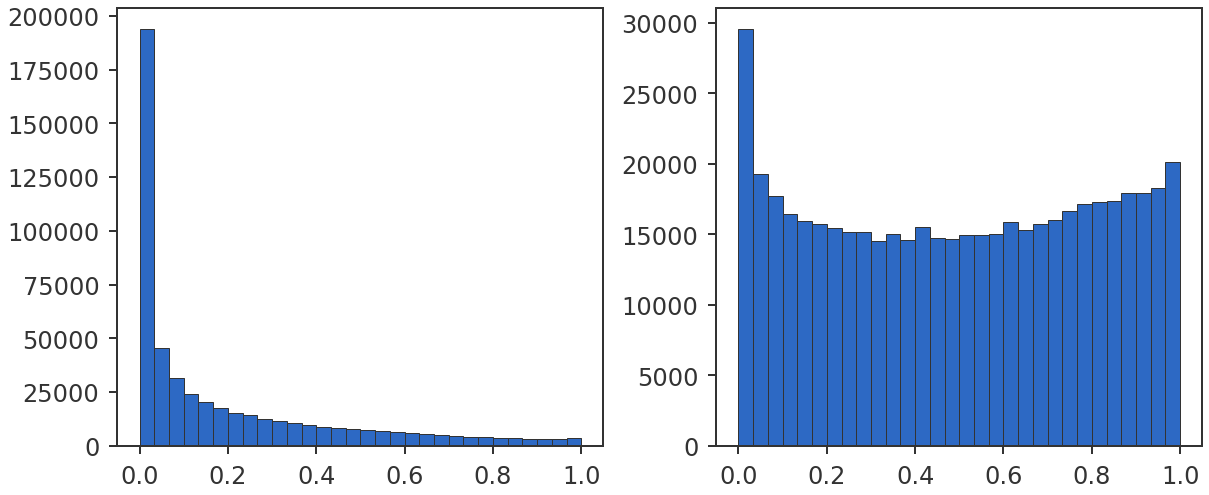

In [5]:
resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2_062020"
resdir2 = "/cbscratch/franco/from_saikat/gtex_v8_202003/ebv/tejaas/raw_std/permnull_sb0.1_knn30/"
tissuelist = ["geu", "gtex_v8-ebv"]
tejaas_preproc = ["raw"] # "raw_oneref"

tejaas_method_variant  = ["permnull_sb0.1_knn30"]

rrfile = "rr.txt"
chrmlist = [1,2]

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals = -np.log10(gwpvals)

filefmt = f'{resdir2}/chr' + "{:d}" + f'/{rrfile}'
gwrsids2, gwnsnps2, gwbppos2, gwpvals2 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals2 = -np.log10(gwpvals2)

# filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[2]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
# gwrsids3, gwnsnps3, gwbppos3, gwpvals3 = read_tejaas_all_chrom(filefmt, chrmlist)
# gwlog10pvals3 = -np.log10(gwpvals3)

# filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas_rand/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
# gwrsids, gwnsnps, gwbppos, gwpvals_rand = read_tejaas_all_chrom(filefmt, chrmlist)
# gwlog10pvals_rand = -np.log10(gwpvals_rand)

# filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[1]}/tejaas_rand/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
# gwrsids2, gwnsnps2, gwbppos2, gwpvals2_rand = read_tejaas_all_chrom(filefmt, chrmlist)
# gwlog10pvals2_rand = -np.log10(gwpvals2_rand)

# filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[2]}/tejaas_rand/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
# gwrsids3, gwnsnps3, gwbppos3, gwpvals3_rand = read_tejaas_all_chrom(filefmt, chrmlist)
# gwlog10pvals3_rand = -np.log10(gwpvals3_rand)


fig = plt.figure(figsize = (17, 7))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

nplotsnp = min(500000, gwpvals.shape[0])
nchoose = np.sort(np.random.choice(gwpvals.shape[0], size = nplotsnp, replace = False))
ax1.hist(gwpvals[nchoose], bins=30)

nplotsnp = min(500000, gwpvals2.shape[0])
nchoose = np.sort(np.random.choice(gwpvals2.shape[0], size = nplotsnp, replace = False))
ax2.hist(gwpvals2[nchoose], bins=30)


# nplotsnp = min(500000, gwpvals_rand.shape[0])
# nchoose = np.sort(np.random.choice(gwpvals_rand.shape[0], size = nplotsnp, replace = False))
# ax1.hist(gwpvals_rand[nchoose], bins=30, label="rand", alpha=0.4)

# nplotsnp = min(500000, gwpvals2_rand.shape[0])
# nchoose = np.sort(np.random.choice(gwpvals2_rand.shape[0], size = nplotsnp, replace = False))
# ax2.hist(gwpvals2_rand[nchoose], bins=30, label="rand", alpha=0.4)


plt.tight_layout()
plt.show()

In [7]:
resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2_062020_NOADM/"
resdir2  = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2_062020_EUR/"

tissuelist = ["gtex_v8-ms", "gtex_v8-as", "gtex_v8-sse"]
tejaas_preproc = ["raw"] # "raw_oneref"

tejaas_method_variant  = ["permnull_sb0.1_knn30"]

rrfile = "rr.txt"
chrmlist = [10,11]

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids_eur, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals_eur = -np.log10(gwpvals)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[1]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids2_eur, gwnsnps2, gwbppos2, gwpvals2 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals2_eur = -np.log10(gwpvals2)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[2]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids3_eur, gwnsnps3, gwbppos3, gwpvals3 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals3_eur = -np.log10(gwpvals3)

filefmt = f'{resdir2}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids_noadm, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals_noadm = -np.log10(gwpvals)

filefmt = f'{resdir2}/{tejaas_preproc[0]}/{tissuelist[1]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids2_noadm, gwnsnps2, gwbppos2, gwpvals2 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals2_noadm = -np.log10(gwpvals2)

filefmt = f'{resdir2}/{tejaas_preproc[0]}/{tissuelist[2]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids3_noadm, gwnsnps3, gwbppos3, gwpvals3 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals3_noadm = -np.log10(gwpvals3)


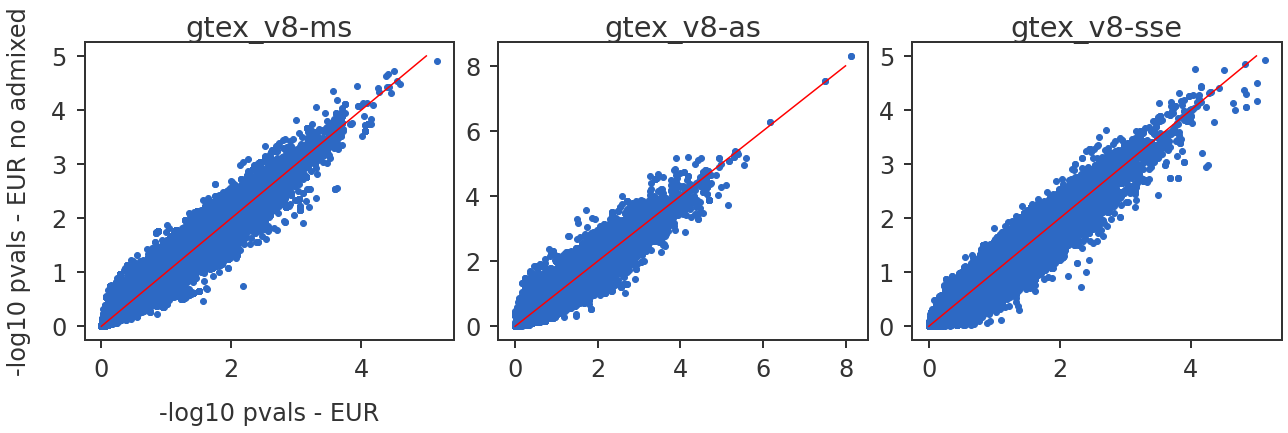

In [17]:

fig = plt.figure(figsize=(18,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

dict_eur   = dict(zip(gwrsids_eur, np.arange(1, len(gwrsids_eur)+1)))
dict_noadm = dict(zip(gwrsids_noadm, np.arange(1, len(gwrsids_noadm)+1)))
common = [x for x in gwrsids_eur if dict_noadm.get(x, False)]
ix_eur = [dict_eur[x]-1 for x in common]
ix_noadm = [dict_noadm[x]-1 for x in common]


dict_eur   = dict(zip(gwrsids2_eur, np.arange(1, len(gwrsids2_eur)+1)))
dict_noadm = dict(zip(gwrsids2_noadm, np.arange(1, len(gwrsids2_noadm)+1)))
common = [x for x in gwrsids2_eur if dict_noadm.get(x, False)]
ix2_eur = [dict_eur[x]-1 for x in common]
ix2_noadm = [dict_noadm[x]-1 for x in common]

dict_eur   = dict(zip(gwrsids3_eur, np.arange(1, len(gwrsids3_eur)+1)))
dict_noadm = dict(zip(gwrsids3_noadm, np.arange(1, len(gwrsids3_noadm)+1)))
common = [x for x in gwrsids3_eur if dict_noadm.get(x, False)]
ix3_eur = [dict_eur[x]-1 for x in common]
ix3_noadm = [dict_noadm[x]-1 for x in common]

ax1.scatter(gwlog10pvals_eur[ix_eur], gwlog10pvals_noadm[ix_noadm])
ax2.scatter(gwlog10pvals2_eur[ix2_eur], gwlog10pvals2_noadm[ix2_noadm])
ax3.scatter(gwlog10pvals3_eur[ix3_eur], gwlog10pvals3_noadm[ix3_noadm])

ax1.plot([0,5],[0,5], color='red')
ax2.plot([0,8],[0,8], color='red')
ax3.plot([0,5],[0,5], color='red')

ax1.set_title(tissuelist[0])
ax2.set_title(tissuelist[1])
ax3.set_title(tissuelist[2])

ax1.set_xlabel("-log10 pvals - EUR")
ax1.set_ylabel("-log10 pvals - EUR no admixed")

plt.tight_layout()
plt.show()

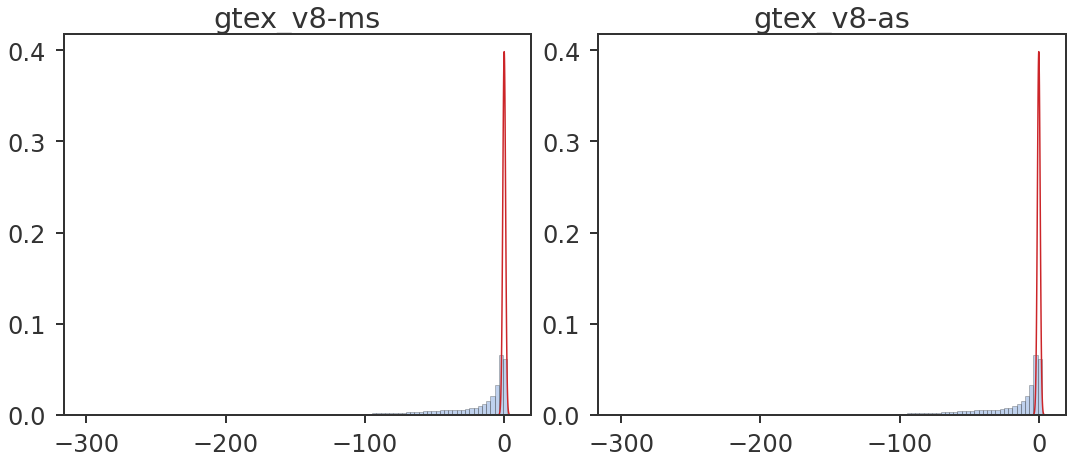

In [4]:
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib

resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_SHAPEIT2_062020/"
tissuelist = ["gtex_v8-ms", "gtex_v8-as"]
tejaas_preproc = ["raw_popcorr"] # "raw_oneref"
tejaas_method_variant  = ["permnull_sb0.1_knn30"]

rrfile = "rr.txt"
chrmlist = [10,11]

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwqvals, gwmus, gwsigs= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
qscaled = (gwqvals - gwmus)/ gwsigs

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwqvals2, gwmus2, gwsigs2= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
qscaled2 = (gwqvals2 - gwmus2)/ gwsigs2

# filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
# gwrsids, gwnsnps, gwqvals3, gwmus3, gwsigs3= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
# qscaled3 = (gwqvals3 - gwmus3)/ gwsigs3


fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax1.hist(qscaled, bins=100, alpha=0.3, density=True)
ax1.set_title(f"{tissuelist[0]}")

ax2 = fig.add_subplot(222)
ax2.hist(qscaled2, bins=100, alpha=0.3, density=True)
ax2.set_title(f"{tissuelist[1]}")

# ax3 = fig.add_subplot(223)
# ax3.hist(qscaled3, bins=100, alpha=0.3, density=True)
# ax3.set_title(f"{tissuelist[2]}")

x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
ax1.plot(x, rv.pdf(x), label = 'analytical')
ax2.plot(x, rv.pdf(x), label = 'analytical')
# ax3.plot(x, rv.pdf(x), label = 'analytical')

plt.tight_layout()
plt.show()

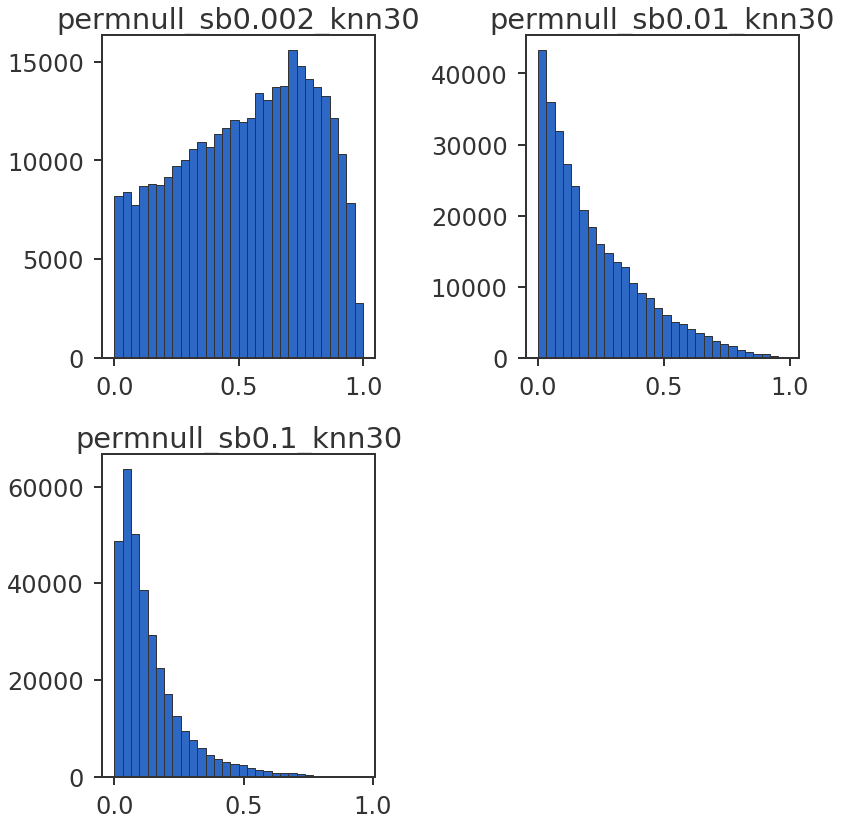

In [23]:
resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/framinghmam_joehannes/"
resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/framinghmam_reproc/"

tissuelist = ["fhs"] 
tejaas_preproc = ["raw_oneref"]
tejaas_preproc = ["raw_linear_oneref"]

tejaas_method_variant  = [ "permnull_sb0.0005_knn30", "permnull_sb0.0007_knn30", "permnull_sb0.001_knn30"]
tejaas_method_variant  = [ "permnull_sb0.002_knn30", "permnull_sb0.01_knn30", "permnull_sb0.1_knn30"]

rrfile = "rr.txt"
chrmlist = [10]

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals = -np.log10(gwpvals)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[1]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids2, gwnsnps2, gwbppos2, gwpvals2 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals2 = -np.log10(gwpvals2)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[2]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids3, gwnsnps3, gwbppos3, gwpvals3 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals3 = -np.log10(gwpvals3)

fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)

nplotsnp = min(500000, gwpvals.shape[0])
nchoose = np.sort(np.random.choice(gwpvals.shape[0], size = nplotsnp, replace = False))
ax1.hist(gwpvals[nchoose], bins=30)
ax1.set_title(f"{tejaas_method_variant[0]}")
# ax1.set_ylim(0,13500)

nplotsnp = min(500000, gwpvals.shape[0])
nchoose = np.sort(np.random.choice(gwpvals2.shape[0], size = nplotsnp, replace = False))
ax2.hist(gwpvals2[nchoose], bins=30)
ax2.set_title(f"{tejaas_method_variant[1]}")

nplotsnp = min(500000, gwpvals.shape[0])
nchoose = np.sort(np.random.choice(gwpvals3.shape[0], size = nplotsnp, replace = False))
ax3.hist(gwpvals3[nchoose], bins=30)
ax3.set_title(f"{tejaas_method_variant[2]}")


plt.tight_layout()
plt.show()

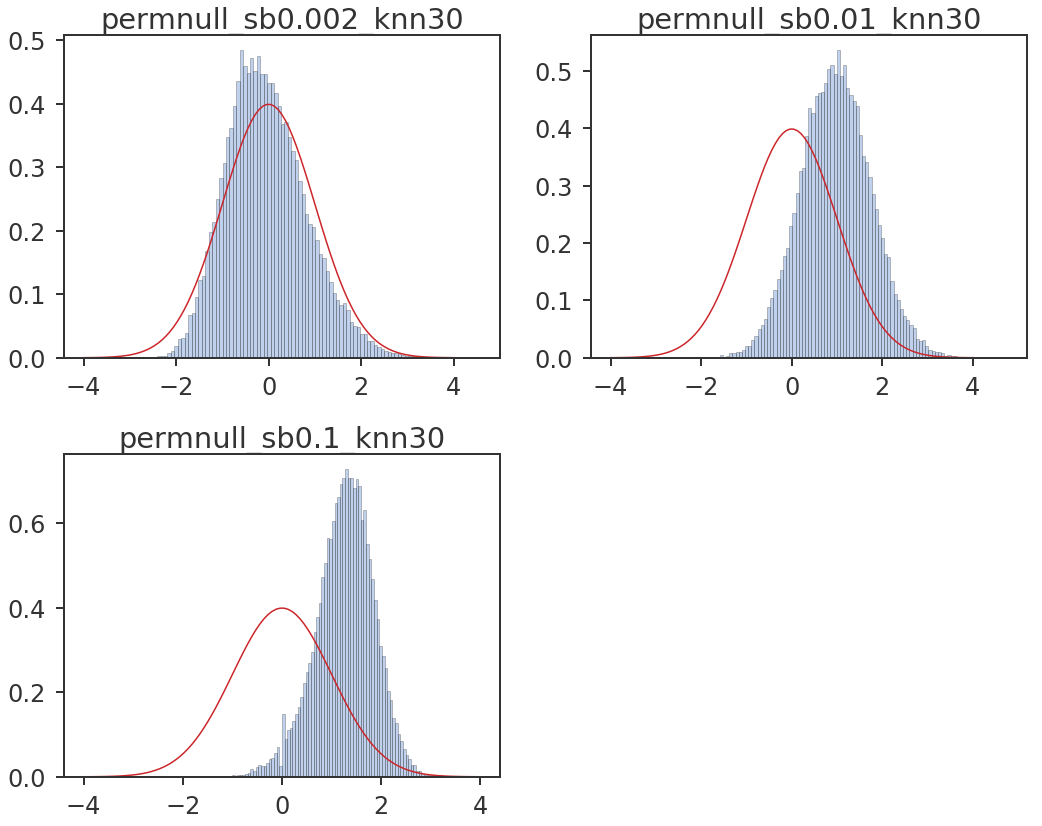

In [21]:
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib

resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/framinghmam_joehannes/"
resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/framinghmam_reproc/"

tissuelist = ["fhs"] 
tejaas_preproc = ["raw_oneref"]
tejaas_preproc = ["raw_linear_oneref"]

tejaas_method_variant  = [ "permnull_sb0.0005_knn30", "permnull_sb0.0007_knn30", "permnull_sb0.001_knn30"]
tejaas_method_variant  = [ "permnull_sb0.002_knn30", "permnull_sb0.01_knn30", "permnull_sb0.1_knn30"]

rrfile = "rr.txt"
chrmlist = [10]

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwqvals, gwmus, gwsigs= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
qscaled = (gwqvals - gwmus)/ gwsigs

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[1]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwqvals2, gwmus2, gwsigs2= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
qscaled2 = (gwqvals2 - gwmus2)/ gwsigs2

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[2]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwqvals3, gwmus3, gwsigs3= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
qscaled3 = (gwqvals3 - gwmus3)/ gwsigs3


fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax1.hist(qscaled, bins=100, alpha=0.3, density=True)
ax1.set_title(f"{tejaas_method_variant[0]}")

ax2 = fig.add_subplot(222)
ax2.hist(qscaled2, bins=100, alpha=0.3, density=True)
ax2.set_title(f"{tejaas_method_variant[1]}")

ax3 = fig.add_subplot(223)
ax3.hist(qscaled3, bins=100, alpha=0.3, density=True)
ax3.set_title(f"{tejaas_method_variant[2]}")

x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
ax1.plot(x, rv.pdf(x), label = 'analytical')
ax2.plot(x, rv.pdf(x), label = 'analytical')
ax3.plot(x, rv.pdf(x), label = 'analytical')

plt.tight_layout()
plt.show()

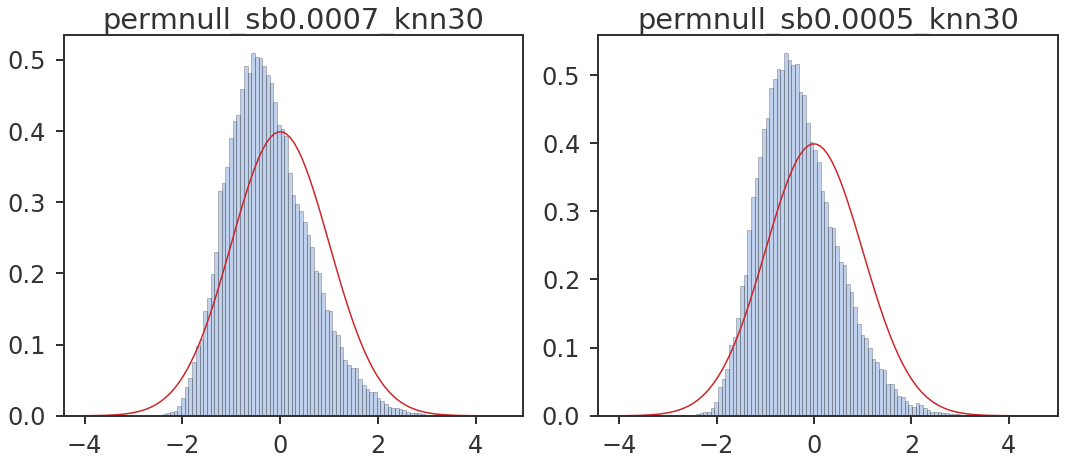

In [4]:
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib

resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/framinghmam_joehannes"
tissuelist = ["fhs"] 
tejaas_preproc = ["raw_oneref_adj"]
tejaas_preproc = ["raw_oneref"]


tejaas_method_variant  = [ "permnull_sb0.0007_knn30", "permnull_sb0.0005_knn30"]

rrfile = "rr.txt"
chrmlist = [10]#11,12]

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwqvals, gwmus, gwsigs= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
qscaled = (gwqvals - gwmus)/ gwsigs

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[1]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwqvals2, gwmus2, gwsigs2= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
qscaled2 = (gwqvals2 - gwmus2)/ gwsigs2

# filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[2]}/chr' + "{:d}" + f'/{rrfile}'
# gwrsids, gwnsnps, gwqvals3, gwmus3, gwsigs3= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
# qscaled3 = (gwqvals3 - gwmus3)/ gwsigs3


fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax1.hist(qscaled, bins=100, alpha=0.3, density=True)
ax1.set_title(f"{tejaas_method_variant[0]}")

ax2 = fig.add_subplot(222)
ax2.hist(qscaled2, bins=100, alpha=0.3, density=True)
ax2.set_title(f"{tejaas_method_variant[1]}")

# ax3 = fig.add_subplot(223)
# ax3.hist(qscaled3, bins=100, alpha=0.3, density=True)
# ax3.set_title(f"{tejaas_method_variant[2]}")

x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
ax1.plot(x, rv.pdf(x), label = 'analytical')
ax2.plot(x, rv.pdf(x), label = 'analytical')
# ax3.plot(x, rv.pdf(x), label = 'analytical')

plt.tight_layout()
plt.show()

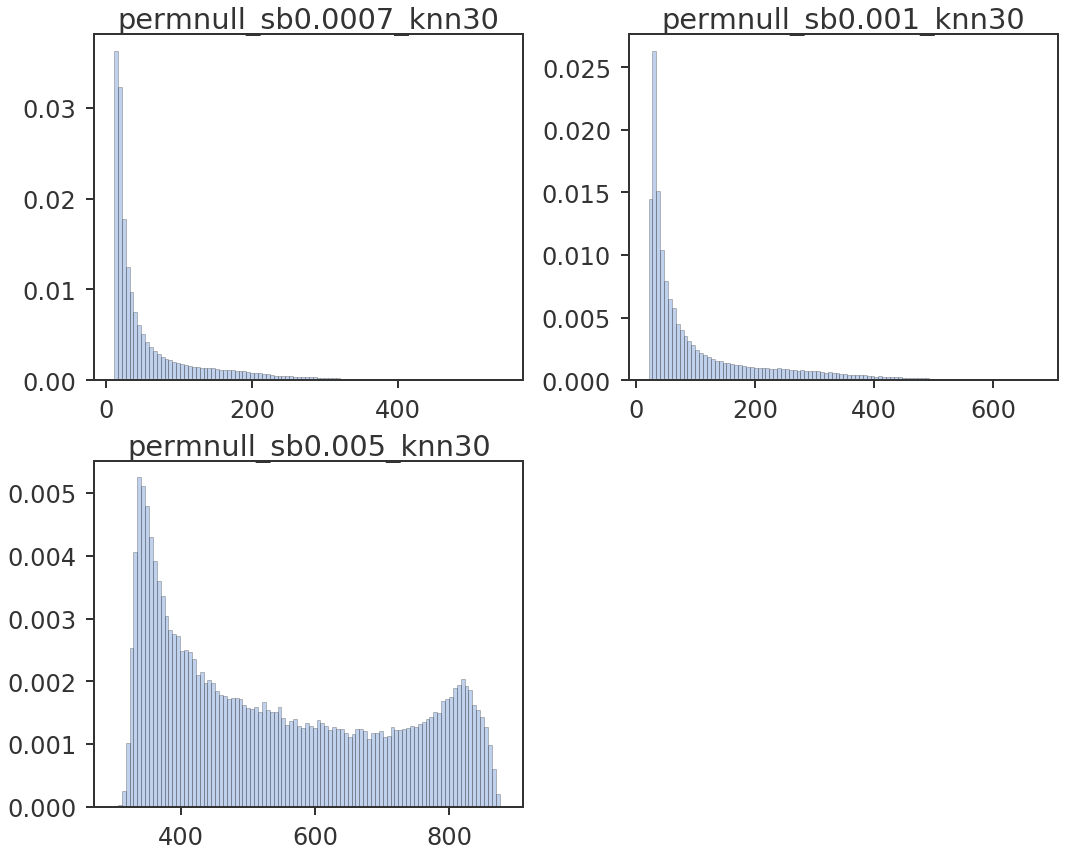

In [34]:
from scipy import stats
from scipy.interpolate import interp1d
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib

resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/framinghmam_16032020/"
tissuelist = ["fhs"] 
tejaas_preproc = ["raw_oneref_adj"]
tejaas_preproc = ["raw_oneref"]


tejaas_method_variant  = [ "permnull_sb0.0007_knn30", "permnull_sb0.001_knn30", "permnull_sb0.005_knn30"]

rrfile = "rr.txt"
chrmlist = [10,11,12]

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwqvals, gwmus, gwsigs= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
qscaled = gwqvals

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[1]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwqvals2, gwmus2, gwsigs2= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
qscaled2 = gwqvals2

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[2]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwqvals3, gwmus3, gwsigs3= read_Qstats_tejaas_all_chrom(filefmt, chrmlist)
qscaled3 = gwqvals3


fig = plt.figure(figsize=(15,12))
ax1 = fig.add_subplot(221)
ax1.hist(qscaled, bins=100, alpha=0.3, density=True)
ax1.set_title(f"{tejaas_method_variant[0]}")

ax2 = fig.add_subplot(222)
ax2.hist(qscaled2, bins=100, alpha=0.3, density=True)
ax2.set_title(f"{tejaas_method_variant[1]}")

ax3 = fig.add_subplot(223)
ax3.hist(qscaled3, bins=100, alpha=0.3, density=True)
ax3.set_title(f"{tejaas_method_variant[2]}")

x = np.linspace(-4, 4, 100)
rv = stats.norm(loc = 0, scale = 1)
# ax1.plot(x, rv.pdf(x), label = 'analytical')
# ax2.plot(x, rv.pdf(x), label = 'analytical')
# ax3.plot(x, rv.pdf(x), label = 'analytical')

plt.tight_layout()
plt.show()

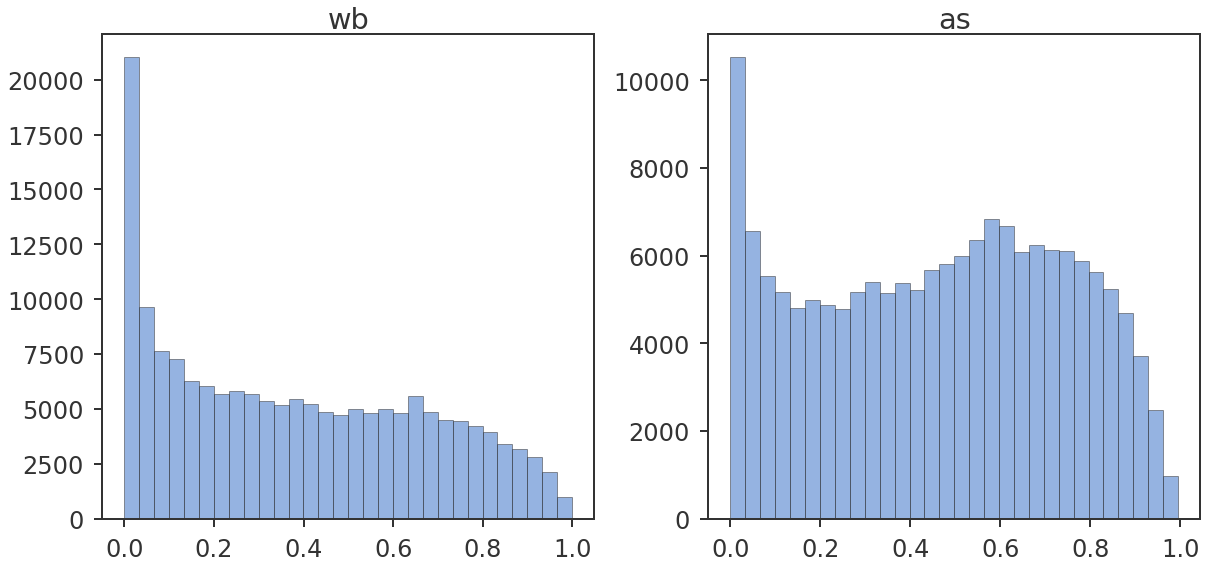

In [10]:
resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/gtex_v8_opt_sb2_EUR/"
tissuelist = ["gtex_v8-wb", "gtex_v8-as"]
tejaas_preproc = ["raw"] 

tejaas_method_variant  = ["permnull_sb0.1_knn30"]

rrfile = "rr.txt"
chrmlist = [12]

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom_old(filefmt, chrmlist)
gwlog10pvals = -np.log10(gwpvals)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[1]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids2, gwnsnps2, gwbppos2, gwpvals2 = read_tejaas_all_chrom_old(filefmt, chrmlist)
gwlog10pvals2 = -np.log10(gwpvals2)

# filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas_rand/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
# gwrsids3, gwnsnps3, gwbppos3, gwpvals3 = read_tejaas_all_chrom_old(filefmt, chrmlist)
# gwlog10pvals3 = -np.log10(gwpvals3)

# filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[1]}/tejaas_rand/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
# gwrsids4, gwnsnps4, gwbppos4, gwpvals4 = read_tejaas_all_chrom_old(filefmt, chrmlist)
# gwlog10pvals4 = -np.log10(gwpvals4)

fig = plt.figure(figsize = (17, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
# ax3 = fig.add_subplot(143)
# ax4 = fig.add_subplot(144)

nplotsnp = min(1000000, gwpvals.shape[0])
nchoose = np.sort(np.random.choice(gwpvals.shape[0], size = nplotsnp, replace = False))
ax1.hist(gwpvals[nchoose], bins=30, alpha=0.5, label="actual")
# ax1.hist(gwpvals3[nchoose], bins=30, alpha=0.5, label="rand")
ax1.set_title("wb")
# ax1.set_ylim(0,31500)

nplotsnp = min(1000000, gwpvals2.shape[0])
nchoose = np.sort(np.random.choice(gwpvals2.shape[0], size = nplotsnp, replace = False))
ax2.hist(gwpvals2[nchoose], bins=30, alpha=0.5, label="actual")
# ax2.hist(gwpvals4[nchoose], bins=30, alpha=0.5, label="rand")
ax2.set_title("as")
# ax2.set_ylim(0,31500)

# ax3.hist(gwpvals3[nchoose], bins=30)
# ax3.set_title("sb 0.7")
# # ax3.set_ylim(0,31500)

# ax4.hist(gwpvals4[nchoose], bins=30)
# ax4.set_title("sb 0.8")
# # ax3.set_ylim(0,31500)
plt.tight_layout()

plt.show()

#### Manhattan Plot

In [7]:
def plot_manhattan(ax, chrmlist, nsnps, bppos, log10pvals, log10cutoff):
    
    i = 0
    start = 0
    lastbp = 0
    xtickposlist = list()
    
    for chrm in chrmlist:
        end = start + nsnps[chrm]
        chrm_bppos = bppos[chrm]
        xtickposlist.append(lastbp + int((chrm_bppos[0] + chrm_bppos[-1]) / 2))

        y = log10pvals[start:end]
        nchoose = np.where(y >= log10cutoff)
        x = lastbp + chrm_bppos[nchoose]
        ax.scatter(x, y[nchoose], alpha = 1.0, s = 6)
        nchoose = np.where(y < log10cutoff)
        nchoose_sparse = np.sort(np.random.choice(nchoose[0], int(nchoose[0].shape[0] / 20), replace=False))
        x = lastbp + chrm_bppos[nchoose_sparse]
        ax.scatter(x, y[nchoose_sparse], color='gainsboro', s = 5, alpha = 0.8)
        
        start = end
        lastbp += chrm_bppos[-1]
        
    ax.set_xlim(0, lastbp)
    ax.plot([0, lastbp], [log10cutoff, log10cutoff], ls = 'dashed', color='gainsboro')
    ax.set_xticks(xtickposlist)
    ax.set_xticklabels(["{:d}".format(x) for x in chrmlist])
    
    return

def plot_manhattan_top(ax, chrmlist, nsnps, bppos, log10pvals, log10cutoff):
    
    i = 0
    start = 0
    lastbp = 0
    xtickposlist = list()
    
    for chrm in chrmlist:
        end = start + nsnps[chrm]
        chrm_bppos = bppos[chrm]
        xtickposlist.append(lastbp + int((chrm_bppos[0] + chrm_bppos[-1]) / 2))

        y = log10pvals[start:end]
        nchoose = np.where(y >= log10cutoff)
        x = lastbp + chrm_bppos[nchoose]
        ax.scatter(x, y[nchoose], alpha = 1.0, s = 6)
        nchoose = np.where(y < log10cutoff)
        nchoose_sparse = np.sort(np.random.choice(nchoose[0], int(nchoose[0].shape[0] / 20), replace=False))
        x = lastbp + chrm_bppos[nchoose_sparse]
        ax.scatter(x, y[nchoose_sparse], color='gainsboro', s = 5, alpha = 0.8)
        
        start = end
        lastbp += chrm_bppos[-1]
        
    ax.set_xlim(0, lastbp)
    ax.plot([0, lastbp], [log10cutoff, log10cutoff], ls = 'dashed', color='gainsboro')
    ax.set_xticks(xtickposlist)
    ax.set_xticklabels(["{:d}".format(x) for x in chrmlist])
    
    return

In [30]:
resdir  = "/cbscratch/franco/trans-eqtl/dev-pipeline/framinghmam_16032020/"
tissuelist = ["fhs", "fhs"]
tejaas_preproc = ["raw_oneref_adj"] 

tejaas_method_variant  = ["permnull_sb0.001_knn30", "permnull_sb0.002_knn30"]

rrfile = "rr.txt"
chrmlist = np.arange(10,13)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[0]}/tejaas/{tejaas_method_variant[0]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids, gwnsnps, gwbppos, gwpvals = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals = -np.log10(gwpvals)

filefmt = f'{resdir}/{tejaas_preproc[0]}/{tissuelist[1]}/tejaas/{tejaas_method_variant[1]}/chr' + "{:d}" + f'/{rrfile}'
gwrsids2, gwnsnps2, gwbppos2, gwpvals2 = read_tejaas_all_chrom(filefmt, chrmlist)
gwlog10pvals2 = -np.log10(gwpvals2)


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in greater_equal
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in less


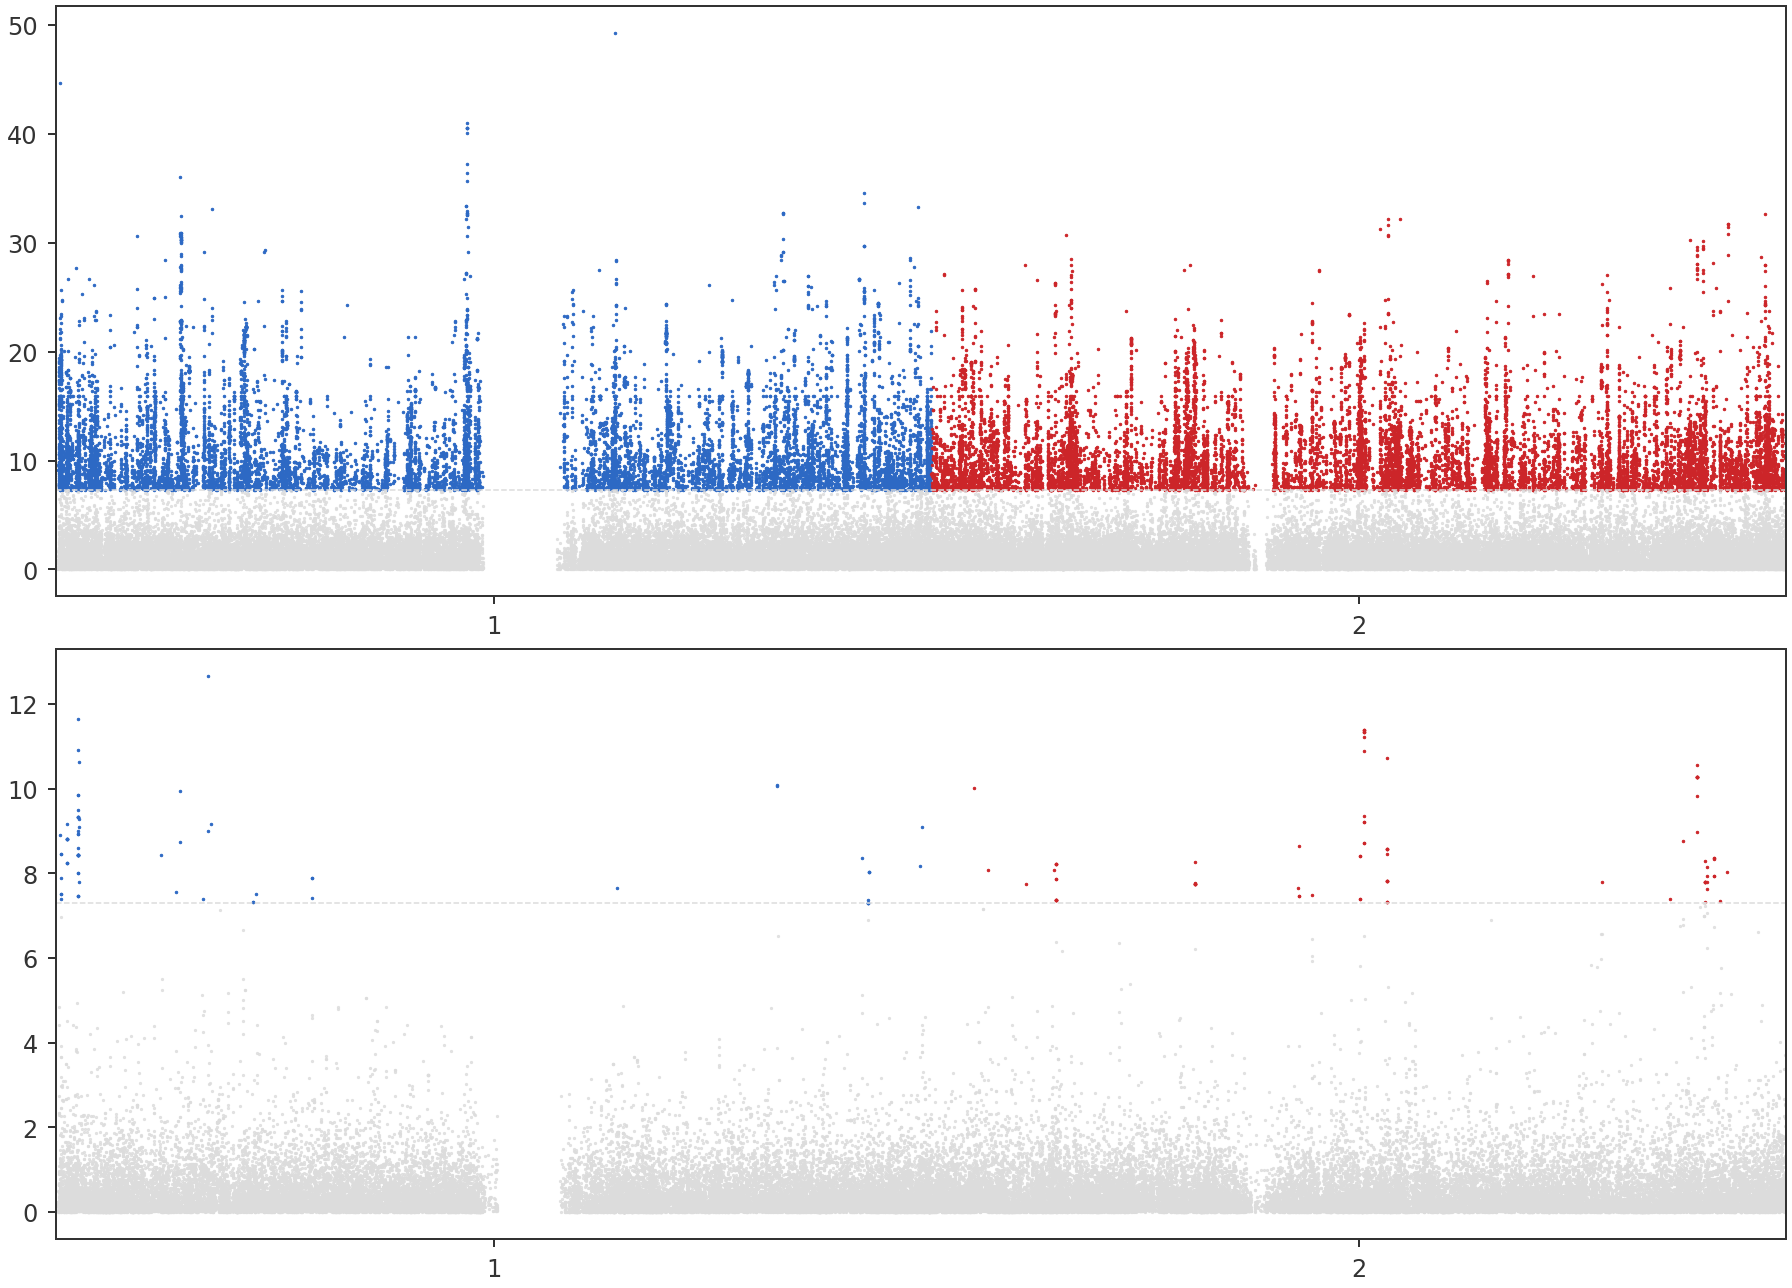

In [8]:
fig = plt.figure(figsize = (25, 18))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

log10cutoff = -np.log10(5e-8)

plot_manhattan_top(ax1, chrmlist, gwnsnps, gwbppos, gwlog10pvals, log10cutoff)
plot_manhattan(ax2, chrmlist, gwnsnps2, gwbppos2, gwlog10pvals2, log10cutoff)
# plot_manhattan(ax2, chrmlist, gwnsnps3, gwbppos3, gwlog10pvals3, log10cutoff)

plt.tight_layout()

# outfile = '../plots/manhattan_as_sse.png'
# plt.savefig(outfile, bbox_inches='tight')

plt.show()